In [10]:
import numpy as np
import random
import matplotlib.pyplot as plt

### Say we have a bunch of points. And we wish to find out the probability density of these points, KDE comes handy.

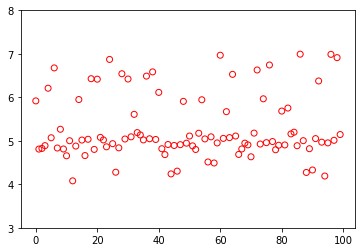

In [108]:
N = 100
random.seed(42)
x = [5 + random.uniform(-1,2) if (i%2 == 0) else 5 + random.uniform(-0.2,0.2) for i in range(N)]
#mostly centered around 5, with positive bias

plt.figure()
plt.scatter(range(N), x, facecolor='none', edgecolor = 'r')
plt.ylim([3,8]);

### Formally, the KDE is the function $\hat{g_n}(x) = \frac{1}{nh}\Sigma_{i=1}^{h} K\bigg(\frac{X_i - x}{h}\bigg)$

#### $K$ is the kernel function. We will explore a few later. $h$ is the bandwith, $X_i$ is each datapoint. There are $n$ such datapoints

In [182]:
#Try a gaussian kernel
def gaussian(x):
    return 1/np.sqrt(2*np.pi) * np.exp(-x**2/2)

x_test = np.linspace(3,8,100) #dataset span
def get_dist_gaussian(x, h):
    plist = []
    for xq in x_test:
        p = np.sum([gaussian((x[i]-xq)/h) for i in range(len(x))])
        plist.append(p/(len(x)*h))
    return plist

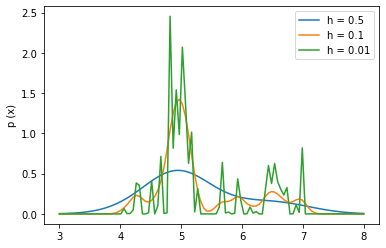

In [170]:
fig, ax = plt.subplots()
p = get_dist_gaussian(x, h = 0.5)
ax.plot(x_test, p, label = 'h = {}'.format(0.5))
p = get_dist_gaussian(x, h = 0.1)
ax.plot(x_test, p, label = 'h = {}'.format(0.1))
p = get_dist_gaussian(x, h = 0.01)
ax.plot(x_test, p, label = 'h = {}'.format(0.01))
ax.set_label('x')
ax.set_ylabel('p (x)')
ax.legend();

### Varying the bandwith makes all the difference in the world. For this dataset, we want it to peak at 5, but we also want to see slight bias in right side of the tail (it shouldn't drop off easily). Setting h to 0.5 allows us to see both features

### Choice of the bandwith $h$ is sometimes far more important than the choice of the kernel itself. We have to develop techniques to optimize for $h$

### 3.0.1 Least Squares Cross Validation Bandwith
### Define $R(g)=\int [g(x)]^2 dx$. The cross validation part comes from the fact that we will go over all the datapoints, and each time we will remove a datapoint $X_j$ and then predict that datapoint itself (leave-one-out cross validation). Compute the pdf from the kernel without that datapoint $\hat{g_n(x)}$. Do that for all $X_j$ and sum that up. Then multiply it by -2/n and subtract from $R(\hat{g})$. This can be done for different $h$. Repeat and choose the one that minimizes this value.
### Find argmin$_{h} \{R(g) - \frac{2}{n}\Sigma_{i}^{n}\hat{g}_n(x)\}$, where we are evaluating $\hat{g}_n(x)$ without a datapoint at that datapoint each time.

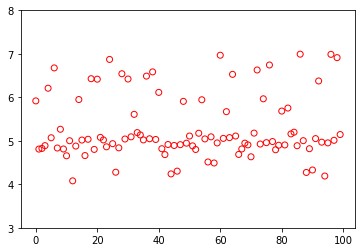

In [172]:
#same data

N = 100
random.seed(42)
x = [5 + random.uniform(-1,2) if (i%2 == 0) else 5 + random.uniform(-0.2,0.2) for i in range(N)]
#mostly centered around 5, with positive bias

plt.figure()
plt.scatter(range(N), x, facecolor='none', edgecolor = 'r')
plt.ylim([3,8]);

In [178]:
def get_psum(x, h):
    
    p_sum = 0
    
    index_list = [i for i in range(N)]
    for i in range(N):

        #select a random index from the list of indices
        j = random.choice(index_list)
        index_list.pop(index_list.index(j))

        #choose the datapoint to be excluded
        X_j = x[j]
        p = np.sum([gaussian((x[i]-X_j)/h) for i in range(len(x)) if i!=j])
        p_sum += p
        
    return p_sum


###
from scipy.integrate import simpson
from sklearn.metrics import auc
def R_g(x, h):
    
    p_list = get_dist_gaussian(x, h)
    #p_sq = get_dist_gaussian(p_list, h) #apply gaussian function to gaussian result to get g_sq
    #point of contention: is it g(x)^2 or g^2(x)???
    p_sq = [x**2 for x in p_list]
    area = auc(x_test, p_sq) #can also use area = simpson(p_sq, dx=5/100) or np.trapz(p_sq, dx=5/100)
    
    return area

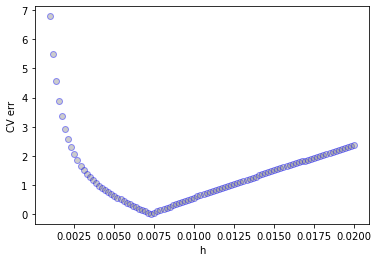

In [179]:
hlist = np.linspace(0.001,0.02,100)
n = 100
plt.figure()
for h in hlist:
    err = R_g(x,h)-(2/n)*get_psum(x, h)
    plt.scatter(h, abs(err), marker = 'o', facecolor = 'gray', edgecolor = 'b', alpha = 0.4)
plt.xlabel('h')
plt.ylabel('CV err')
plt.show()

#### Gorgeous plot but not sure I believe it. CV suggests h optimum to be around 0.0075.

## 3.0.2 Asymptotic Mean Integrated Squares of Errors (AMISE)

### We minimize the AMISE, which is $\frac{1}{nh}R(K) + \frac{h^4}{4}\{\mu_2(K)\}^2 \int_{-\infty}^{\infty}\{\hat{g}''(x)\}^2 dx$, where $\mu_2(K) = \int_{-\infty}^{\infty}x^2K(x) dx$.
### The solution for $h$ that minimizes this expression is given as $h = \bigg[ \frac{R(K)}{n\mu_2^{2}(K) R\{\hat{g}''(x)\}} \bigg]^{1/5}$

### However, there is a major issue. We want to optimize for $h$, but $\hat{g}(x)$ depends on $h$. So we need to approximate $\hat{g}(x)$. To do so, we can use Silverman's rule of thumb: 

### i) optimal $h = \bigg(\frac{4\sigma^5}{3n}\bigg)^{1/5}$, where $\sigma$ is the standard deviation of the datapoints. Let's try that first, and then also try the silverman approximation for our function and plug in our expression for optimum h above.

In [176]:
sigma = np.std(x)
h_opt = (4*sigma**5/(3*len(x)))**1/5
print(h_opt)

0.0005316004261238966


### This is absolutely awful! Looks like Silverman's approximation may not be good.

### ii) or, say that the density belongs to a family of Gaussians (which is similar, but not quite). Then $R\{\hat{g}''(x)\} \approx 0.212\sigma^{-5}$, and use the formula $h = \bigg[ \frac{R(K)}{n\mu_2^{2}(K) R\{\hat{g}''(x)\}} \bigg]^{1/5}$

In [177]:
def R_k(x):
    x.sort() #have to sort before calculating area
    gauss = [gaussian(xi) for xi in x]
    g_sq = [x**2 for x in gauss]
    area = auc(x, g_sq)
    return area

def mu_2_sq(x):
    x.sort()
    gauss = [gaussian(xi) for xi in x]
    integrand = [gauss[i]*x[i]**2 for i in range(len(x))] #x^2*K(x)
    area = auc(x, integrand)
    return area

Rk = R_k(x)
mu2sq = mu_2_sq(x)
psi4 = 0.212*sigma**(-5)

h_opt = (Rk/(n*mu2sq*psi4))**(1/5)
print(h_opt)

0.030491063723060662


### Not entirely unreasonable?

## 3.0.3 Adaptive bandwith
### i.e. $\hat{g_n}(x) = \Sigma_{i=1}^{n} \frac{1}{nh_i}K\bigg(\frac{X_i - x}{h_i}\bigg)$
### The goal is to widen $h$ whenever we have few points and to make it slimmer when we have more points (very intuitive if you think about histogram binning).

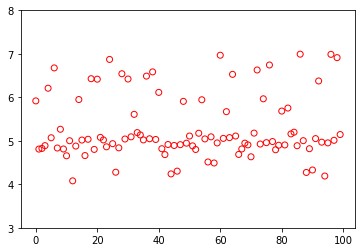

In [180]:
#our good old dataset:

N = 100
random.seed(42)
x = [5 + random.uniform(-1,2) if (i%2 == 0) else 5 + random.uniform(-0.2,0.2) for i in range(N)]
#mostly centered around 5, with positive bias

plt.figure()
plt.scatter(range(N), x, facecolor='none', edgecolor = 'r')
plt.ylim([3,8]);

### Step 1 is to choose an h anyway. Say we want 0.03. 
### Call this distribution $f_h$
### Step 2, we loop over each datapoint and compute $G = \bigg(\Pi_{i=1}^{n}f_h(x_i)\bigg)^{1/n}$
### Then, $h_i = h\sqrt{\frac{G}{f_h(x_i)}}$
### And, now that we have $h_i$, we can get $\hat{g_n}(x) = \Sigma_{i=1}^{n} \frac{1}{nh_i}K\bigg(\frac{X_i - x}{h_i}\bigg)$

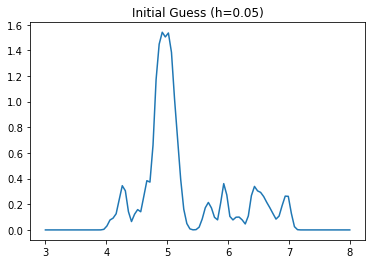

In [225]:
F = get_dist_gaussian(x, 0.05)
plt.title('Initial Guess (h=0.05)')
plt.plot(x_test, F);

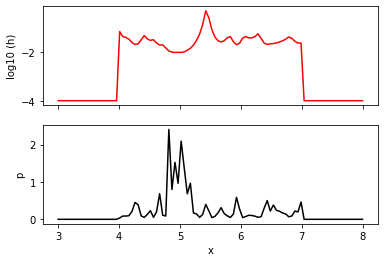

In [228]:
n = len(x_test)
plist = []

def get_hi():
    hi_list = []
    for i in range(len(x_test)):
        #beyond [4,7] products should be ~0. Filter for that
        if (x_test[i] < 4.) | (x_test[i] > 7.):
            hi = 1e-4
        else:
            F_no_zeros = F[int(len(F)/5):int(4/5*len(F))]
            G = np.prod([F_no_zeros])**(1/n)
            hi = h*np.sqrt(G/F[i])
        hi_list.append(hi)
    return hi_list

def adaptive_dist_gaussian(x, h_list):
    plist = []
    for i in range(len(x_test)):
        xq = x_test[i]
        h = h_list[i]
        p = np.sum([gaussian((x[i]-xq)/h) for i in range(len(x))])
        plist.append(p/(len(x)*h))
    return plist

fig, [ax0, ax1] = plt.subplots(2, sharex=True)
hi_list = get_hi()
plist = adaptive_dist_gaussian(x, hi_list)
ax0.plot(x_test, np.log10(hi_list), 'r-')
ax1.plot(x_test, plist, 'k-')
ax1.set_xlabel('x')
ax1.set_ylabel('p')
ax0.set_ylabel('log10 (h)');

### Adaptive h! Although it still looks underestimated to me. Not smooth enough